# World Values Survey Data

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
data = pd.read_sas('data/WVS_CrossNat_W7_v1_6.sas7bdat', format='sas7bdat')

In [3]:
# data.describe()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70867 entries, 0 to 70866
Columns: 547 entries, version to v2xps_party
dtypes: float64(538), object(9)
memory usage: 295.7+ MB


<AxesSubplot:>

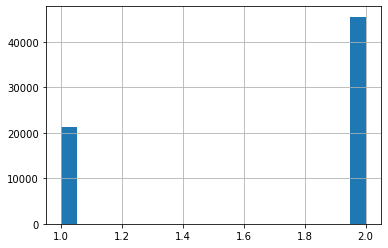

In [5]:
data['Q175'].hist(bins=20)

In [6]:
# drop = ['version', 'doi', 'A_WAVE', 'A_STUDY', 'B_COUNTRY_ALPHA']
# data.drop(drop,axis=1)

In [7]:
from src.pipeline import create_Xy, get_country_codes

In [8]:
X, y = create_Xy(data)

In [9]:
country_codes = get_country_codes()

In [10]:
X.isna().sum().sum()

67155

In [11]:
X.isna().sum().sort_values()[:-20:-1]

Q36     12756
Q22      3670
Q111     3206
Q62      2881
Q107     2333
Q42      2127
Q25      2124
Q32      2009
Q45      2008
Q29      1893
Q31      1473
Q44      1469
Q43      1432
Q28      1344
Q56      1167
Q27      1143
Q30      1108
Q20      1098
Q35      1088
dtype: int64

In [12]:
a = Counter(y[X.isna().any(axis=1)])

In [13]:
a

Counter({20.0: 153,
         32.0: 561,
         36.0: 385,
         50.0: 396,
         68.0: 924,
         76.0: 853,
         152.0: 458,
         156.0: 414,
         170.0: 10,
         196.0: 566,
         276.0: 646,
         218.0: 314,
         818.0: 1200,
         231.0: 373,
         300.0: 447,
         320.0: 135,
         344.0: 183,
         360.0: 254,
         364.0: 1499,
         368.0: 1200,
         400.0: 1203,
         392.0: 1142,
         398.0: 636,
         417.0: 338,
         422.0: 1200,
         446.0: 186,
         484.0: 256,
         566.0: 204,
         558.0: 59,
         554.0: 757,
         586.0: 631,
         604.0: 413,
         608.0: 28,
         630.0: 220,
         642.0: 679,
         643.0: 944,
         688.0: 265,
         764.0: 594,
         762.0: 1200,
         788.0: 1208,
         792.0: 702,
         158.0: 129,
         804.0: 999,
         840.0: 436,
         704.0: 1,
         716.0: 131})

In [14]:
X.shape

(70867, 63)

## Classification modeling

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,
                                                    random_state=0)

In [22]:
X_train.mean()

Q1      1.099541
Q2      1.739812
Q3      1.803974
Q4      2.604400
Q5      1.519441
          ...   
Q107    5.708781
Q108    4.969344
Q109    4.053102
Q110    4.355116
Q111    1.460733
Length: 63, dtype: float64

In [23]:
X_m = X_train.mean()
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
# X = X.fillna(X_m)

In [24]:
X_train.shape

(56693, 63)

In [25]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=100,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.5930577113023846


In [26]:

print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.5930577113023846


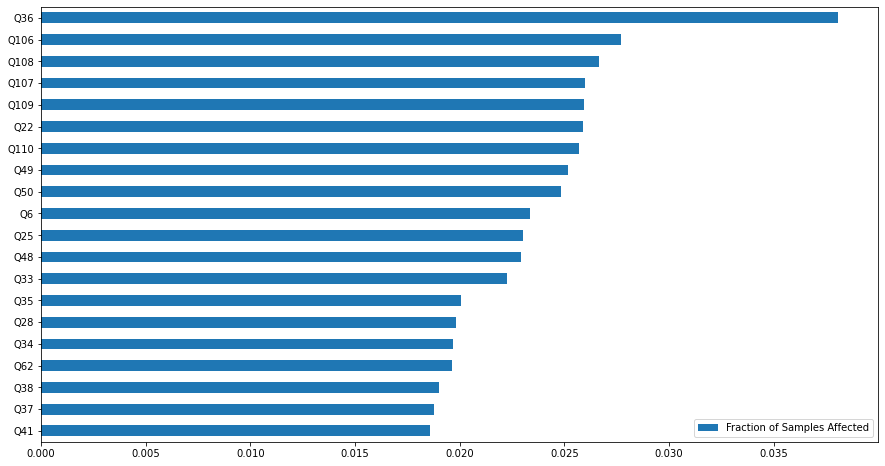

In [27]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores[-20:].plot(kind='barh', figsize=(15,8));

In [28]:
gb = GradientBoostingClassifier(learning_rate=0.1, 
                                  n_estimators=50,
                                  max_depth=3)
gb.fit(X_train, y_train)
y_hat = gb.predict(X_test)
print(f"accuracy = {gb.score(X_test, y_test)}")

accuracy = 0.564766473825314


In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

In [18]:
names = data.columns
 
rf = RandomForestClassifier()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in splitter.split(X.fillna(X_m), y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize=(15,8))

KeyboardInterrupt: 

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
pd.get_dummies(y_train).shape

(56693, 49)

In [35]:
np.random.seed(0)

n_samples, n_feats = X_train.shape
print(n_samples, n_feats)
model = Sequential() # sequence of layers

hidden_units = 49
n_classes = 49

hidden_layer = Dense(49, input_dim=63, kernel_initializer='constant', activation='relu')

output_layer = Dense(49, input_dim=49, kernel_initializer='uniform', activation='softmax')

model.add(hidden_layer)
model.add(output_layer)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

monitor = EarlyStopping(monitor='accuracy', min_delta=1e-2,
                        patience=5, verbose=0, mode='auto', restore_best_weights=True)

model.fit(X_train, pd.get_dummies(y_train), callbacks=[monitor], epochs=10)

56693 63
Epoch 1/10
1772/1772 [==============================] - 1s 352us/step - loss: 3.8714 - accuracy: 0.0445
Epoch 2/10
1772/1772 [==============================] - 1s 347us/step - loss: 3.8450 - accuracy: 0.0446
Epoch 3/10
1772/1772 [==============================] - 1s 344us/step - loss: 3.8411 - accuracy: 0.0455
Epoch 4/10
1772/1772 [==============================] - 1s 347us/step - loss: 3.8427 - accuracy: 0.0447
Epoch 5/10
1772/1772 [==============================] - 1s 346us/step - loss: 3.8411 - accuracy: 0.0454
Epoch 6/10
1772/1772 [==============================] - 1s 346us/step - loss: 3.8411 - accuracy: 0.0457


In [29]:
M = X_train

/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. In

Text(0, 0.5, 'Reconstruction Errror')

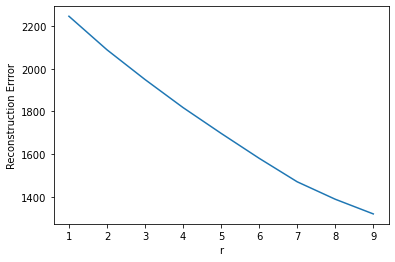

In [30]:
from sklearn.decomposition import NMF

def fit_nmf(r):
    nmf = NMF(n_components=r, init='nndsvd', max_iter=200)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,10)]
plt.plot(range(1,10), error)
plt.xticks(range(1, 10))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [36]:
nmf = NMF(n_components=7)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [37]:
display(H)

In [38]:
nmf.reconstruction_err_

1470.9303002456465

In [39]:
questions = X.columns.values

In [40]:
hand_labels = []
for i, row in enumerate(H):
    top_five = np.argsort(row)[::-1][:10]
    print('topic', i)
    print('-->', ' '.join(questions[top_five]))
    label = input('please label this topic: ')
    hand_labels.append(label)
    print()

topic 0
--> Q33 Q37 Q35 Q30 Q31 Q41 Q29 Q48 Q40 Q28
please label this topic: Women

topic 1
--> Q110 Q108 Q41 Q50 Q6 Q40 Q37 Q38 Q46 Q45
please label this topic: Individual Responsibility

topic 2
--> Q108 Q50 Q49 Q48 Q107 Q34 Q109 Q106 Q38 Q35
please label this topic: happiness

topic 3
--> Q107 Q62 Q61 Q48 Q36 Q47 Q60 Q43 Q3 Q4
please label this topic: control

topic 4
--> Q106 Q48 Q30 Q61 Q33 Q35 Q31 Q4 Q37 Q36
please label this topic: freedom

topic 5
--> Q50 Q49 Q48 Q110 Q106 Q61 Q62 Q43 Q42 Q36
please label this topic: financial success

topic 6
--> Q109 Q62 Q60 Q61 Q59 Q47 Q56 Q4 Q2 Q44
please label this topic: relationships

